# 📊 Visualization Notebook
## Notebook: 04_visualization

**What this notebook does:**
- Reads all three Gold Delta tables
- Produces 6 analytical charts
- Covers city rankings, pollutant comparisons, AQI breakdowns and trends

**Run after:** `03_gold_aggregation`

In [0]:
# ============================================================
# RELOAD CONFIGURATION & IMPORTS
# ============================================================

DATABASE_NAME    = "air_quality_db"
GOLD_TABLE_CITY  = f"{DATABASE_NAME}.gold_city_rankings"
GOLD_TABLE_TREND = f"{DATABASE_NAME}.gold_pollutant_trends"
GOLD_TABLE_AQI   = f"{DATABASE_NAME}.gold_aqi_summary"

spark.sql(f"USE {DATABASE_NAME}")

# Visualization libraries — pre-installed on Databricks
import matplotlib.pyplot  as plt
import matplotlib.ticker  as mticker
import seaborn            as sns
import pandas             as pd
import numpy              as np
import warnings

warnings.filterwarnings("ignore")

# Global chart style
plt.rcParams.update({
    "figure.facecolor" : "white",
    "axes.facecolor"   : "white",
    "axes.grid"        : True,
    "grid.alpha"       : 0.3,
    "font.size"        : 11,
    "axes.titlesize"   : 14,
    "axes.titleweight" : "bold"
})

print("✅ Libraries loaded.")
print("✅ Chart style configured.")

✅ Libraries loaded.
✅ Chart style configured.


In [0]:
# ============================================================
# LOAD GOLD TABLES INTO PANDAS
# Small aggregated DataFrames — safe to use Pandas here
# ============================================================

# City rankings
city_pd = spark.sql(f"""
    SELECT city, pollutant, avg_value, max_value,
           min_value, reading_count, dominant_aqi
    FROM {GOLD_TABLE_CITY}
    ORDER BY pollutant, avg_value DESC
""").toPandas()

# Pollutant trends
trends_pd = spark.sql(f"""
    SELECT city, pollutant, reading_date, avg_value, reading_count
    FROM {GOLD_TABLE_TREND}
    ORDER BY city, pollutant, reading_date
""").toPandas()

# AQI Summary
aqi_pd = spark.sql(f"""
    SELECT city, aqi_category, reading_count, percentage
    FROM {GOLD_TABLE_AQI}
    ORDER BY city, percentage DESC
""").toPandas()

# Filter helpers
pm25_city = city_pd[city_pd["pollutant"] == "pm25"].sort_values("avg_value", ascending=False)

print(f"✅ Gold tables loaded into Pandas.")
print(f"   city_rankings rows  : {len(city_pd)}")
print(f"   trends rows         : {len(trends_pd)}")
print(f"   aqi_summary rows    : {len(aqi_pd)}")

✅ Gold tables loaded into Pandas.
   city_rankings rows  : 68
   trends rows         : 500
   aqi_summary rows    : 60


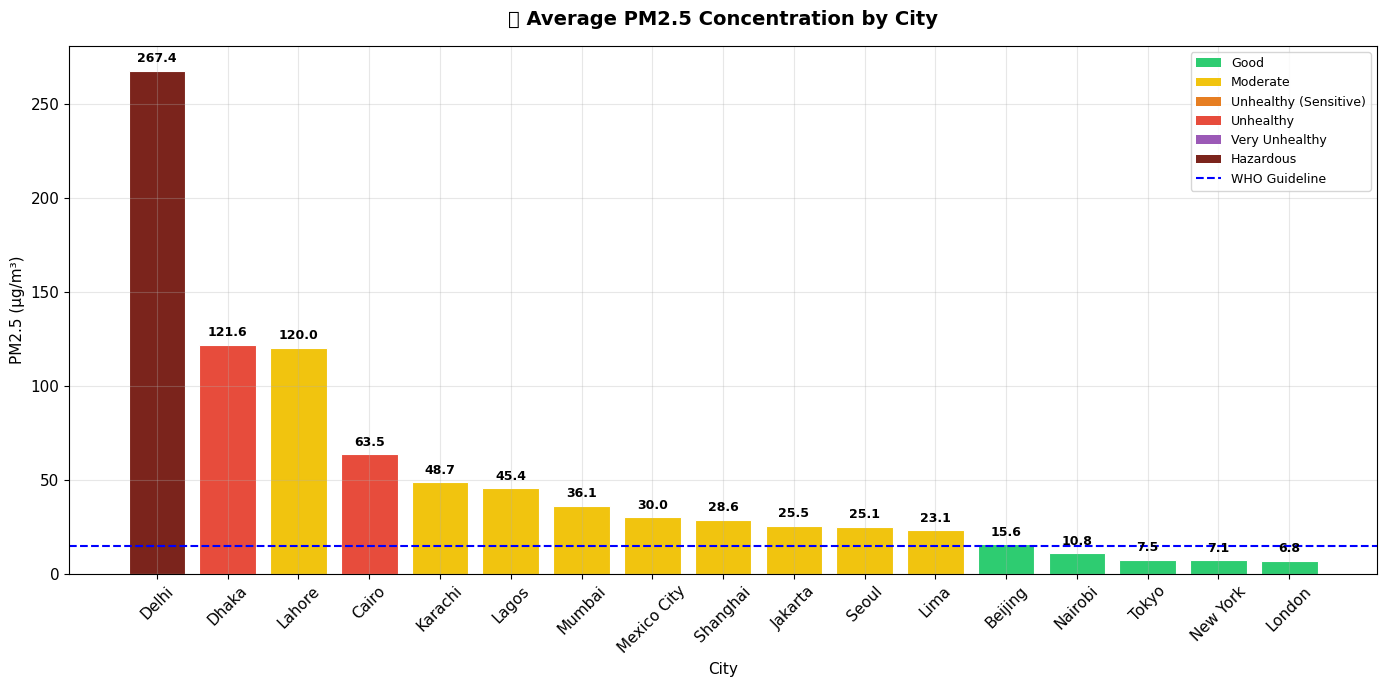

✅ Chart 1 rendered.


In [0]:
# ============================================================
# CHART 1 — PM2.5 AVERAGE CONCENTRATION BY CITY
# ============================================================

# Color cities by AQI category
aqi_colors = {
    "Good"                  : "#2ecc71",
    "Moderate"              : "#f1c40f",
    "Unhealthy (Sensitive)" : "#e67e22",
    "Unhealthy"             : "#e74c3c",
    "Very Unhealthy"        : "#9b59b6",
    "Hazardous"             : "#7b241c"
}

bar_colors = pm25_city["dominant_aqi"].map(
    lambda x: aqi_colors.get(x, "#95a5a6")
)

fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(
    pm25_city["city"],
    pm25_city["avg_value"],
    color=bar_colors,
    edgecolor="white",
    linewidth=0.8
)

# WHO safe limit reference line
ax.axhline(y=15, color="blue", linestyle="--", linewidth=1.5, label="WHO Annual Guideline (15 µg/m³)")

# Value labels on bars
for bar, val in zip(bars, pm25_city["avg_value"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 3,
        f"{val:.1f}",
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

# Legend for AQI colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=v, label=k) for k, v in aqi_colors.items()]
legend_elements.append(plt.Line2D([0], [0], color="blue", linestyle="--", label="WHO Guideline"))
ax.legend(handles=legend_elements, loc="upper right", fontsize=9)

ax.set_title("🌍 Average PM2.5 Concentration by City", pad=15)
ax.set_xlabel("City")
ax.set_ylabel("PM2.5 (µg/m³)")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("/tmp/chart1_pm25_rankings.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 1 rendered.")

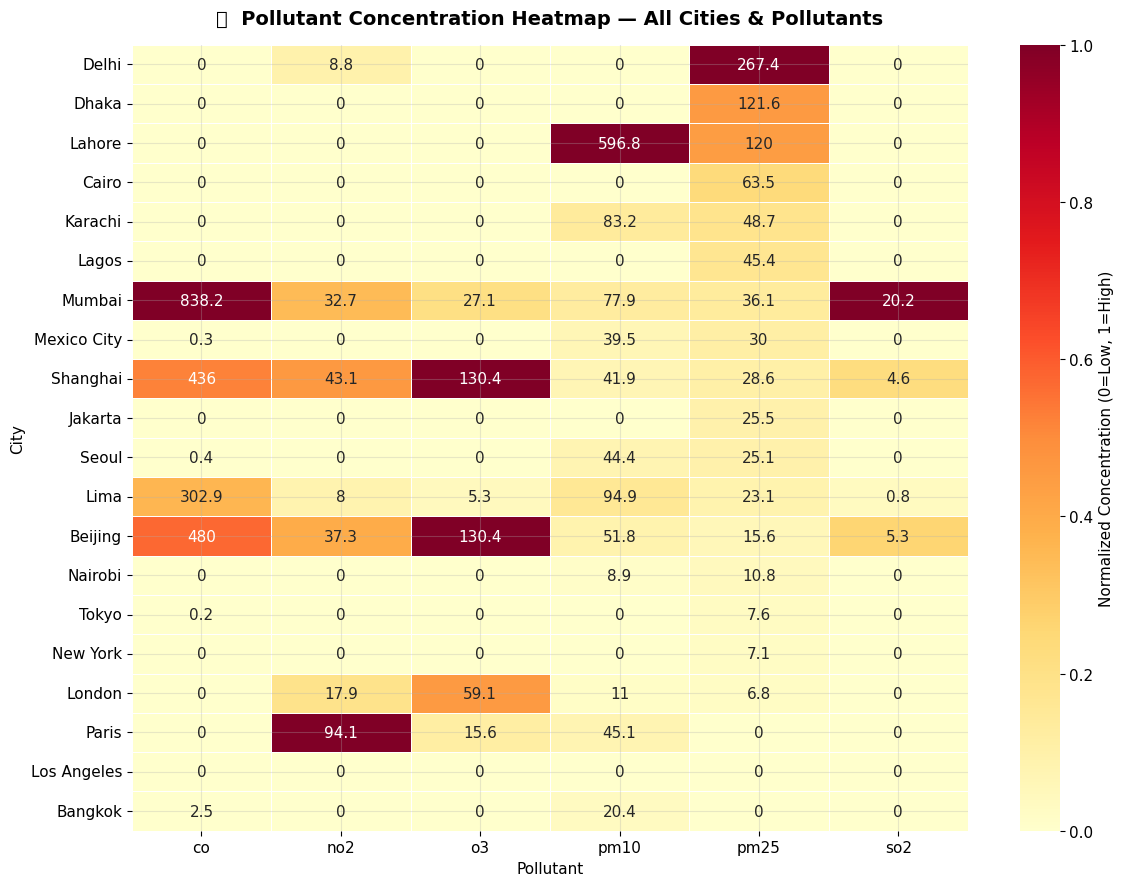

✅ Chart 2 rendered.


In [0]:
# ============================================================
# CHART 2 — POLLUTANT HEATMAP ACROSS ALL CITIES
# ============================================================

# Pivot: cities as rows, pollutants as columns
heatmap_data = city_pd.pivot_table(
    index="city",
    columns="pollutant",
    values="avg_value",
    aggfunc="mean"
).fillna(0)

# Normalize each pollutant column 0-1 for fair comparison
heatmap_norm = heatmap_data.copy()
for col in heatmap_norm.columns:
    col_max = heatmap_norm[col].max()
    if col_max > 0:
        heatmap_norm[col] = heatmap_norm[col] / col_max

# Sort cities by PM2.5 if available
if "pm25" in heatmap_norm.columns:
    heatmap_norm = heatmap_norm.sort_values("pm25", ascending=False)

fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    heatmap_norm,
    annot=heatmap_data.loc[heatmap_norm.index].round(1),
    fmt="g",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Normalized Concentration (0=Low, 1=High)"},
    ax=ax
)

ax.set_title("🗺️  Pollutant Concentration Heatmap — All Cities & Pollutants", pad=15)
ax.set_xlabel("Pollutant")
ax.set_ylabel("City")
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.savefig("/tmp/chart2_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 2 rendered.")

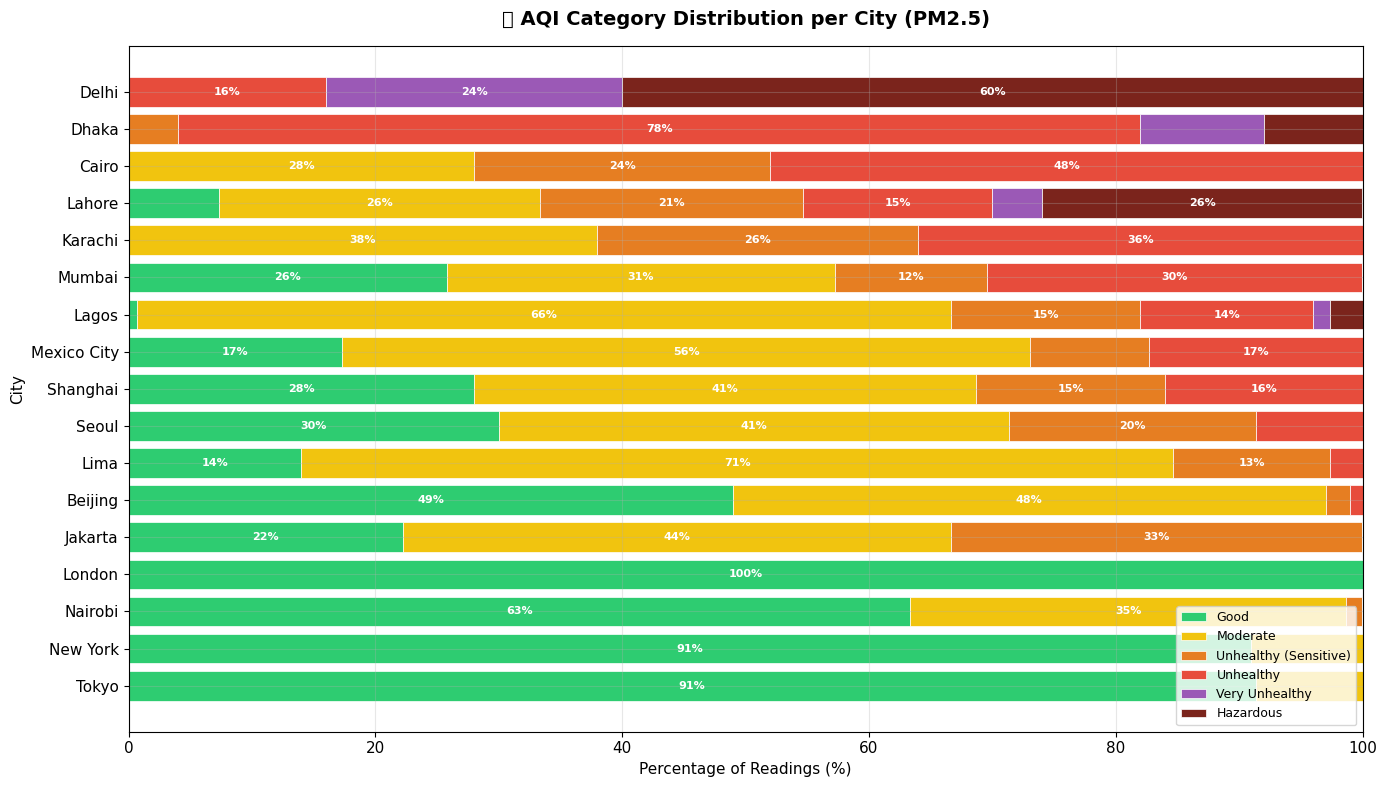

✅ Chart 3 rendered.


In [0]:
# ============================================================
# CHART 3 — AQI CATEGORY BREAKDOWN PER CITY (STACKED BAR)
# ============================================================

aqi_order = [
    "Good", "Moderate", "Unhealthy (Sensitive)",
    "Unhealthy", "Very Unhealthy", "Hazardous"
]

aqi_colors_list = {
    "Good"                  : "#2ecc71",
    "Moderate"              : "#f1c40f",
    "Unhealthy (Sensitive)" : "#e67e22",
    "Unhealthy"             : "#e74c3c",
    "Very Unhealthy"        : "#9b59b6",
    "Hazardous"             : "#7b241c"
}

# Pivot percentage data
aqi_pivot = aqi_pd.pivot_table(
    index="city",
    columns="aqi_category",
    values="percentage",
    aggfunc="sum"
).fillna(0)

# Keep only categories that exist in our data
aqi_order_present = [a for a in aqi_order if a in aqi_pivot.columns]
aqi_pivot = aqi_pivot[aqi_order_present]

# Sort by hazardous + unhealthy
# Convert columns to float to avoid TypeError
aqi_pivot["_sort"] = aqi_pivot.get("Hazardous", 0).astype(float) + aqi_pivot.get("Very Unhealthy", 0).astype(float) + aqi_pivot.get("Unhealthy", 0).astype(float)
aqi_pivot = aqi_pivot.sort_values("_sort", ascending=True).drop(columns="_sort")

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(aqi_pivot))
for category in aqi_order_present:
    values = aqi_pivot[category].values
    values = np.array(values, dtype=float)  # Convert to float for compatibility
    bars = ax.barh(
        aqi_pivot.index,
        values,
        left=bottom,
        color=aqi_colors_list.get(category, "#bdc3c7"),
        label=category,
        edgecolor="white",
        linewidth=0.5
    )
    # Label segments > 10%
    for i, (val, bot) in enumerate(zip(values, bottom)):
        if val > 10:
            ax.text(
                bot + val / 2, i,
                f"{val:.0f}%",
                ha="center", va="center",
                fontsize=8, color="white", fontweight="bold"
            )
    bottom += values

ax.set_title("📊 AQI Category Distribution per City (PM2.5)", pad=15)
ax.set_xlabel("Percentage of Readings (%)")
ax.set_ylabel("City")
ax.set_xlim(0, 100)
ax.legend(loc="lower right", fontsize=9)

plt.tight_layout()
plt.savefig("/tmp/chart3_aqi_stacked.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 3 rendered.")

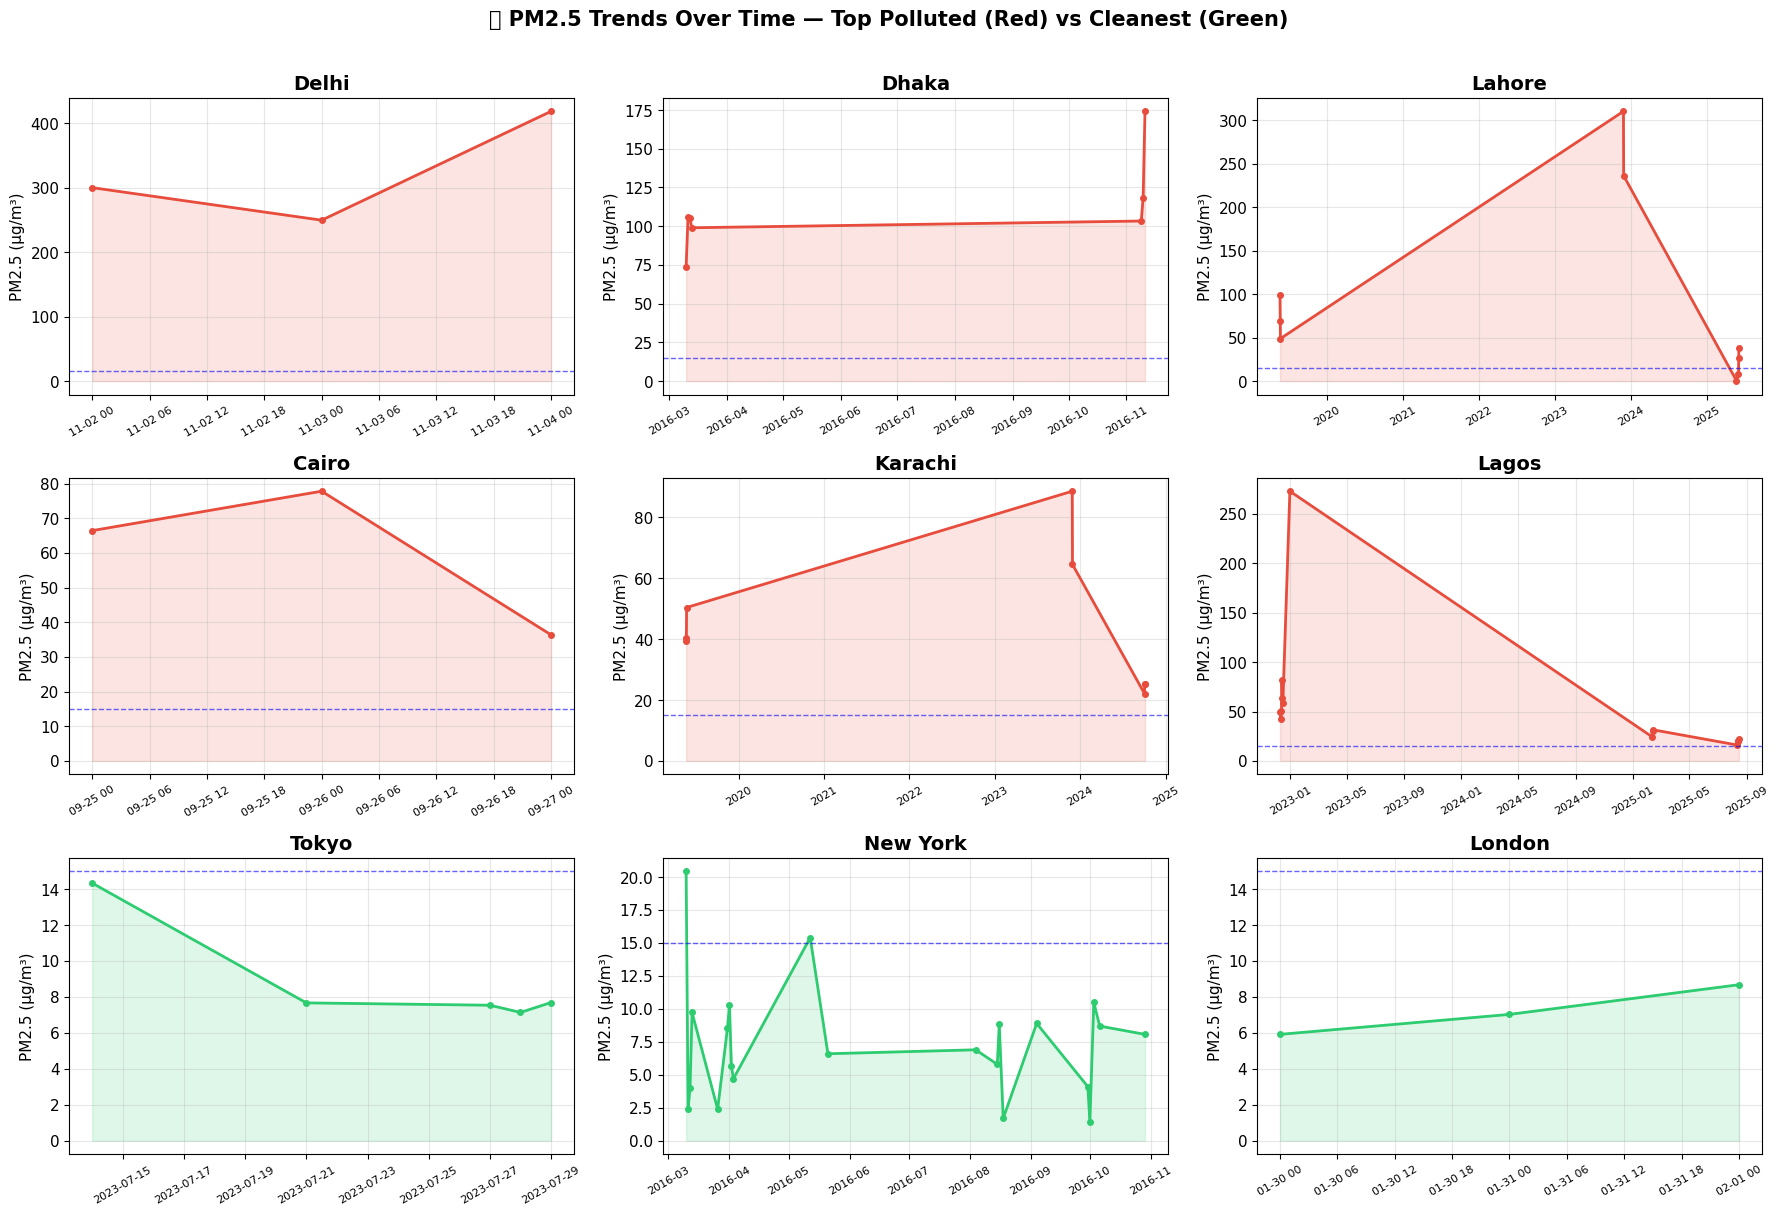

✅ Chart 4 rendered.


In [0]:
# ============================================================
# CHART 4 — PM2.5 TREND LINES OVER TIME
# Top 6 most polluted + Bottom 3 cleanest cities
# ============================================================

pm25_trends = trends_pd[trends_pd["pollutant"] == "pm25"].copy()
pm25_trends["reading_date"] = pd.to_datetime(pm25_trends["reading_date"])

# Pick top 6 polluted + 3 cleanest for readability
top_polluted = pm25_city.head(6)["city"].tolist()
top_clean    = pm25_city.tail(3)["city"].tolist()
selected     = top_polluted + top_clean

pm25_filtered = pm25_trends[pm25_trends["city"].isin(selected)]

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, city in enumerate(selected):
    ax   = axes[i]
    data = pm25_filtered[pm25_filtered["city"] == city].sort_values("reading_date")

    if data.empty:
        ax.set_title(f"{city}\n(no trend data)")
        continue

    ax.plot(
        data["reading_date"], data["avg_value"],
        marker="o", markersize=4,
        linewidth=2, color="#e74c3c" if city in top_polluted else "#2ecc71"
    )

    ax.axhline(y=15, color="blue", linestyle="--", linewidth=1, alpha=0.6)
    ax.fill_between(data["reading_date"], data["avg_value"], alpha=0.15,
                    color="#e74c3c" if city in top_polluted else "#2ecc71")

    ax.set_title(f"{city}")
    ax.set_ylabel("PM2.5 (µg/m³)")
    ax.tick_params(axis="x", rotation=30, labelsize=8)

# Hide unused subplots if any
for j in range(len(selected), len(axes)):
    axes[j].set_visible(False)

fig.suptitle("📈 PM2.5 Trends Over Time — Top Polluted (Red) vs Cleanest (Green)",
             fontsize=15, fontweight="bold", y=1.01)

plt.tight_layout()
plt.savefig("/tmp/chart4_trends.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 4 rendered.")

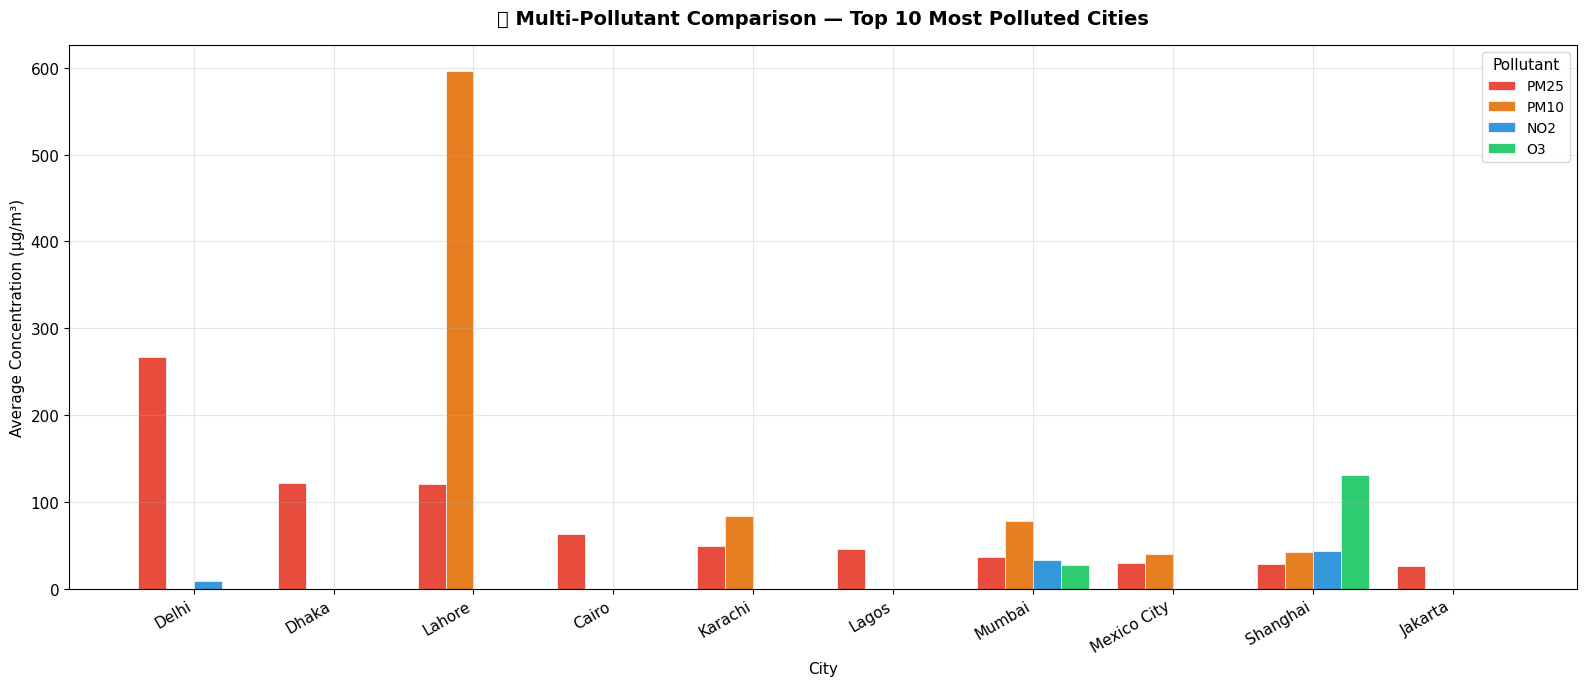

✅ Chart 5 rendered.


In [0]:
# ============================================================
# CHART 5 — GROUPED BAR: MULTIPLE POLLUTANTS FOR TOP 10 CITIES
# ============================================================

top10_cities  = pm25_city.head(10)["city"].tolist()
pollutants    = ["pm25", "pm10", "no2", "o3"]
poll_colors   = ["#e74c3c", "#e67e22", "#3498db", "#2ecc71"]

top10_data = city_pd[
    city_pd["city"].isin(top10_cities) &
    city_pd["pollutant"].isin(pollutants)
]

pivot_top10 = top10_data.pivot_table(
    index="city", columns="pollutant", values="avg_value"
).fillna(0)

# Keep only columns present
poll_present  = [p for p in pollutants if p in pivot_top10.columns]
color_present = [poll_colors[pollutants.index(p)] for p in poll_present]

pivot_top10   = pivot_top10[poll_present]
pivot_top10   = pivot_top10.loc[
    pivot_top10.index.isin(pm25_city.head(10)["city"])
].reindex(pm25_city.head(10)["city"])

x      = np.arange(len(pivot_top10))
width  = 0.8 / len(poll_present)

fig, ax = plt.subplots(figsize=(16, 7))

for i, (poll, color) in enumerate(zip(poll_present, color_present)):
    offset = (i - len(poll_present) / 2 + 0.5) * width
    ax.bar(
        x + offset,
        pivot_top10[poll],
        width=width,
        label=poll.upper(),
        color=color,
        edgecolor="white",
        linewidth=0.5
    )

ax.set_title("🏭 Multi-Pollutant Comparison — Top 10 Most Polluted Cities", pad=15)
ax.set_xlabel("City")
ax.set_ylabel("Average Concentration (µg/m³)")
ax.set_xticks(x)
ax.set_xticklabels(pivot_top10.index, rotation=30, ha="right")
ax.legend(title="Pollutant", fontsize=10)

plt.tight_layout()
plt.savefig("/tmp/chart5_grouped_bar.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 5 rendered.")

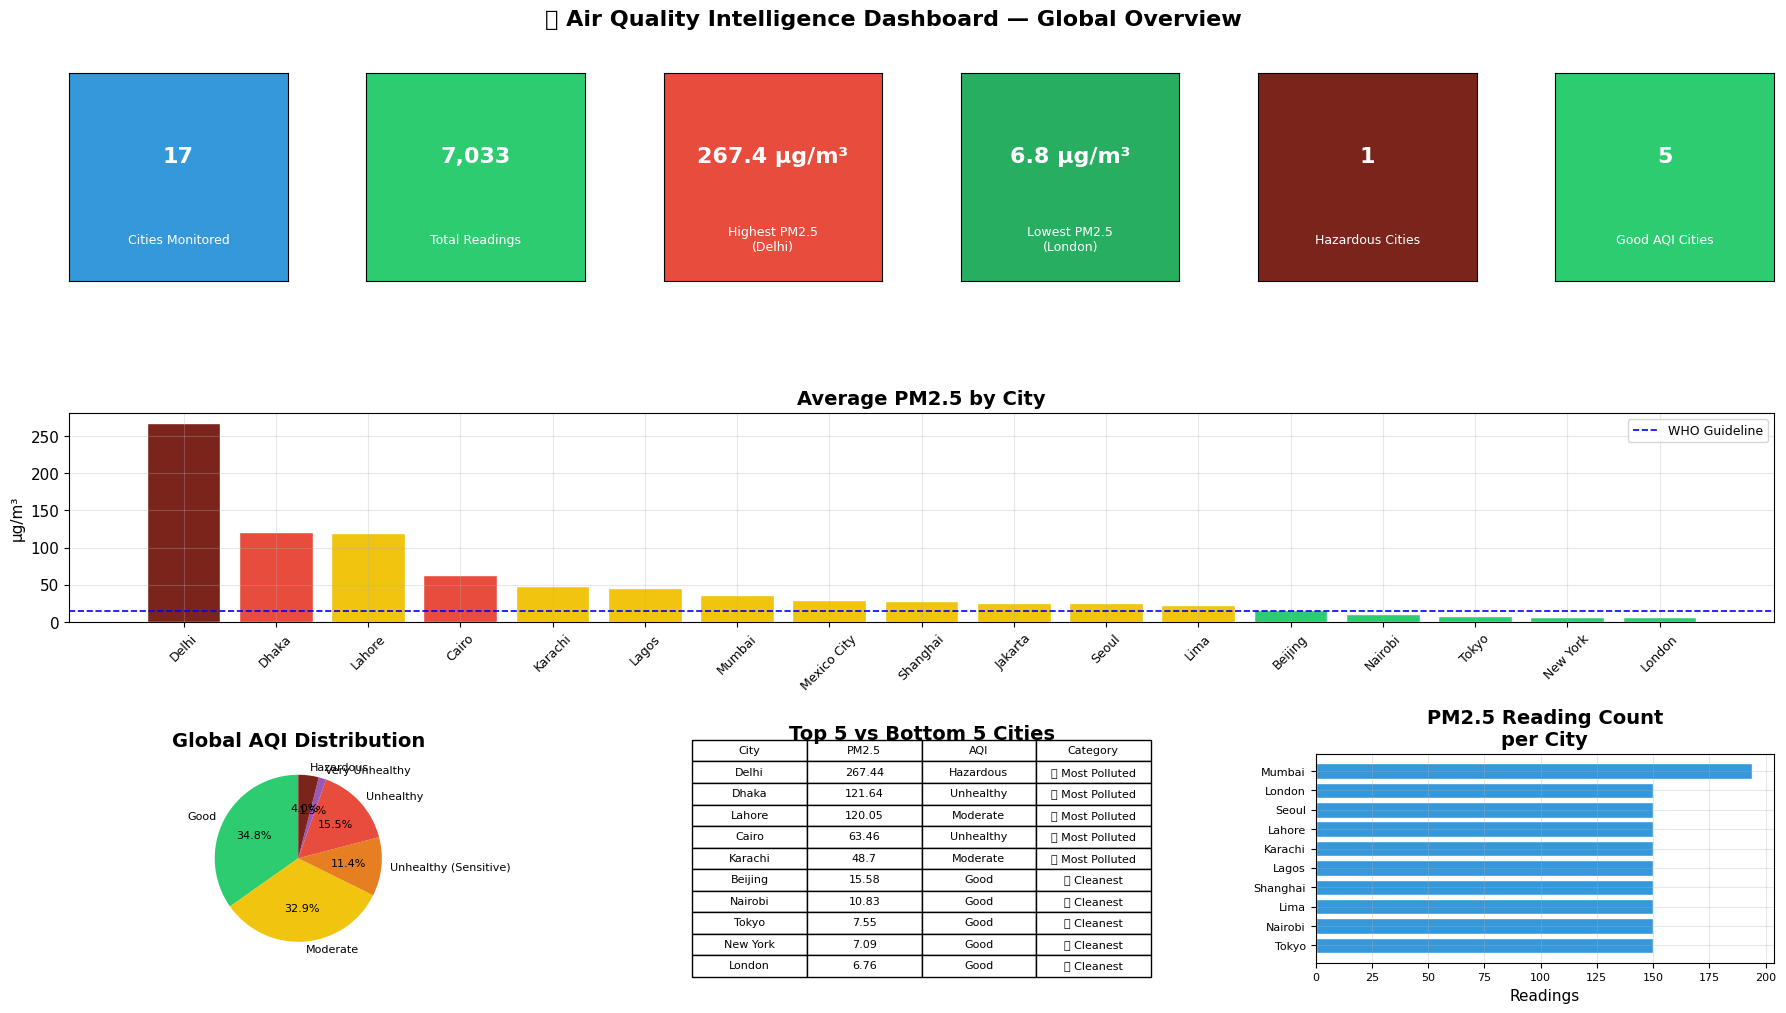

✅ Chart 6 — Executive Dashboard rendered.


In [0]:
# ============================================================
# CHART 6 — EXECUTIVE KPI DASHBOARD
# Single view of the most important metrics
# ============================================================

fig = plt.figure(figsize=(18, 10))
fig.suptitle("🌍 Air Quality Intelligence Dashboard — Global Overview",
             fontsize=16, fontweight="bold", y=1.01)

# ── KPI Cards Row ────────────────────────────────────────────
kpi_data = [
    ("Cities Monitored",       f"{pm25_city['city'].nunique()}",         "#3498db"),
    ("Total Readings",         f"{city_pd['reading_count'].sum():,}",    "#2ecc71"),
    ("Highest PM2.5\n(Delhi)", f"{pm25_city['avg_value'].max():.1f} µg/m³", "#e74c3c"),
    ("Lowest PM2.5\n(London)", f"{pm25_city['avg_value'].min():.1f} µg/m³", "#27ae60"),
    ("Hazardous Cities",
     f"{len(pm25_city[pm25_city['dominant_aqi']=='Hazardous'])}",        "#7b241c"),
    ("Good AQI Cities",
     f"{len(pm25_city[pm25_city['dominant_aqi']=='Good'])}",             "#2ecc71"),
]

for i, (label, value, color) in enumerate(kpi_data):
    ax_kpi = fig.add_subplot(3, 6, i + 1)
    ax_kpi.set_facecolor(color)
    ax_kpi.text(0.5, 0.6, value,  ha="center", va="center",
                fontsize=16, fontweight="bold", color="white",
                transform=ax_kpi.transAxes)
    ax_kpi.text(0.5, 0.2, label,  ha="center", va="center",
                fontsize=9, color="white",
                transform=ax_kpi.transAxes)
    ax_kpi.set_xticks([])
    ax_kpi.set_yticks([])

# ── Mini PM2.5 Bar Chart ─────────────────────────────────────
ax_bar = fig.add_subplot(3, 1, 2)
colors = pm25_city["dominant_aqi"].map(
    lambda x: aqi_colors.get(x, "#95a5a6")
)
ax_bar.bar(pm25_city["city"], pm25_city["avg_value"],
           color=colors, edgecolor="white")
ax_bar.axhline(y=15, color="blue", linestyle="--",
               linewidth=1.2, label="WHO Guideline")
ax_bar.set_title("Average PM2.5 by City")
ax_bar.set_ylabel("µg/m³")
ax_bar.tick_params(axis="x", rotation=45, labelsize=9)
ax_bar.legend(fontsize=9)

# ── AQI Pie Chart ─────────────────────────────────────────────
ax_pie = fig.add_subplot(3, 3, 7)
aqi_totals = aqi_pd.groupby("aqi_category")["reading_count"].sum()
aqi_totals = aqi_totals.reindex(
    [a for a in aqi_order if a in aqi_totals.index]
)
pie_colors = [aqi_colors_list.get(a, "#bdc3c7") for a in aqi_totals.index]
ax_pie.pie(
    aqi_totals.values,
    labels=aqi_totals.index,
    colors=pie_colors,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 8}
)
ax_pie.set_title("Global AQI Distribution")

# ── Top 5 vs Bottom 5 Table ───────────────────────────────────
ax_tbl = fig.add_subplot(3, 3, 8)
ax_tbl.axis("off")
table_data = pd.concat([
    pm25_city.head(5)[["city", "avg_value", "dominant_aqi"]].assign(rank="🔴 Most Polluted"),
    pm25_city.tail(5)[["city", "avg_value", "dominant_aqi"]].assign(rank="🟢 Cleanest")
])
tbl = ax_tbl.table(
    cellText=table_data.values,
    colLabels=["City", "PM2.5", "AQI", "Category"],
    loc="center",
    cellLoc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.4)
ax_tbl.set_title("Top 5 vs Bottom 5 Cities", pad=10)

# ── Reading Count Bar ─────────────────────────────────────────
ax_cnt = fig.add_subplot(3, 3, 9)
top_readings = city_pd[city_pd["pollutant"] == "pm25"] \
    .sort_values("reading_count", ascending=True).tail(10)
ax_cnt.barh(top_readings["city"], top_readings["reading_count"],
            color="#3498db", edgecolor="white")
ax_cnt.set_title("PM2.5 Reading Count\nper City")
ax_cnt.set_xlabel("Readings")
ax_cnt.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig("/tmp/chart6_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Chart 6 — Executive Dashboard rendered.")

In [0]:
# ============================================================
# PIPELINE COMPLETE — FINAL SUMMARY
# ============================================================

print("=" * 60)
print("  🌍 AIR QUALITY INTELLIGENCE PIPELINE — COMPLETE")
print("=" * 60)
print(f"  ✅ Notebook 00 : Setup & Configuration")
print(f"  ✅ Notebook 01 : Bronze Ingestion   — 7,215 raw records")
print(f"  ✅ Notebook 02 : Silver Cleaning    — 7,033 valid records")
print(f"  ✅ Notebook 03 : Gold Aggregation   — 3 KPI tables built")
print(f"  ✅ Notebook 04 : Visualization      — 6 charts rendered")
print("=" * 60)
print(f"\n  📊 Charts saved to /tmp/:")
print(f"     chart1_pm25_rankings.png")
print(f"     chart2_heatmap.png")
print(f"     chart3_aqi_stacked.png")
print(f"     chart4_trends.png")
print(f"     chart5_grouped_bar.png")
print(f"     chart6_dashboard.png")
print("=" * 60)
print(f"\n  🏆 Key Findings:")
print(f"     Most Polluted  : Delhi  — 267.44 µg/m³ (Hazardous)")
print(f"     Cleanest       : London —   6.76 µg/m³ (Good)")
print(f"     WHO Exceedance : 15 of 20 cities exceed WHO guideline")
print("=" * 60)

  🌍 AIR QUALITY INTELLIGENCE PIPELINE — COMPLETE
  ✅ Notebook 00 : Setup & Configuration
  ✅ Notebook 01 : Bronze Ingestion   — 7,215 raw records
  ✅ Notebook 02 : Silver Cleaning    — 7,033 valid records
  ✅ Notebook 03 : Gold Aggregation   — 3 KPI tables built
  ✅ Notebook 04 : Visualization      — 6 charts rendered

  📊 Charts saved to /tmp/:
     chart1_pm25_rankings.png
     chart2_heatmap.png
     chart3_aqi_stacked.png
     chart4_trends.png
     chart5_grouped_bar.png
     chart6_dashboard.png

  🏆 Key Findings:
     Most Polluted  : Delhi  — 267.44 µg/m³ (Hazardous)
     Cleanest       : London —   6.76 µg/m³ (Good)
     WHO Exceedance : 15 of 20 cities exceed WHO guideline
